# Fine-Tuning a BERT Model and Create a Text Classifier

In the previous section, we've already performed the Feature Engineering to create BERT embeddings from the `reviews_body` text using the pre-trained BERT model, and split the dataset into train, validation and test files. To optimize for Tensorflow training, we saved the files in TFRecord format. 

Now, let’s fine-tune the BERT model to our Customer Reviews Dataset and add a new classification layer to predict the `star_rating` for a given `review_body`.

![BERT Training](img/bert_training.png)

As mentioned earlier, BERT’s attention mechanism is called a Transformer. This is, not coincidentally, the name of the popular BERT Python library, “Transformers,” maintained by a company called HuggingFace. We will use a variant of BERT called [DistilBert](https://arxiv.org/pdf/1910.01108.pdf) which requires less memory and compute, but maintains very good accuracy on our dataset.

In [1]:
!pip install -q pip --upgrade
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0

#### _It's OK if you see `ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.` ^^ above ^^_   This is OK!

In [2]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig

In [3]:
%store -r max_seq_length

In [4]:
print(max_seq_length)

64


In [5]:
batch_size=8
epochs=1
steps_per_epoch=50
validation_steps=50
test_steps=50
CLASSES = [1, 2, 3, 4, 5]

In [6]:
def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }
    y = record['label_ids']

    return (x, y)

In [7]:
def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                     drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print('***** Using pipe_mode with channel {}'.format(channel))
        from sagemaker_tensorflow import PipeModeDataset
        dataset = PipeModeDataset(channel=channel,
                                  record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(epochs * steps_per_epoch)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)
        
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=batch_size,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42,
                                  buffer_size=10,
                                  reshuffle_each_iteration=True)

    return dataset

In [8]:
train_data = './data-tfrecord/bert-train'

In [9]:
train_data_filenames = glob('{}/*.tfrecord'.format(train_data))
print('train_data_filenames {}'.format(train_data_filenames))
train_dataset = file_based_input_dataset_builder(
    channel='train',
    input_filenames=train_data_filenames,
    pipe_mode=False,
    is_training=True,
    drop_remainder=False).map(select_data_and_label_from_record)

train_data_filenames ['./data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-train/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-train/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [10]:
validation_data = './data-tfrecord/bert-validation'

In [11]:
validation_data_filenames = glob('{}/*.tfrecord'.format(validation_data))

print('validation_data_filenames {}'.format(validation_data_filenames))
validation_dataset = file_based_input_dataset_builder(
    channel='validation',
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

validation_data_filenames ['./data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-validation/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-validation/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']


In [12]:
test_data = './data-tfrecord/bert-test'

In [13]:
test_data_filenames = glob('{}/*.tfrecord'.format(test_data))

print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel='test',
    input_filenames=test_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

['./data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']
***** Using input_filenames ['./data-tfrecord/bert-test/part-algo-2-amazon_reviews_us_Digital_Video_Games_v1_00.tfrecord', './data-tfrecord/bert-test/part-algo-1-amazon_reviews_us_Digital_Software_v1_00.tfrecord']


In [14]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                          num_labels=len(CLASSES))
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              config=config)

# Setup the Custom Classifier Model Here

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.layers[0].trainable = False
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3845      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,957,317
Trainable params: 594,437
Non-trainable params: 66,362,880
_________________________________________________________________


In [16]:
callbacks = []

log_dir = './tmp/tensorboard/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [17]:
history = model.fit(train_dataset,
                    shuffle=True,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    callbacks=callbacks)

Train for 50 steps, validate for 50 steps
50/50 [==============================] - 15s 292ms/step - loss: 1.5758 - accuracy: 0.2925 - val_loss: 0.8461 - val_accuracy: 0.0000e+00


In [18]:
print('Trained model {}'.format(model))

Trained model <transformers.modeling_tf_distilbert.TFDistilBertForSequenceClassification object at 0x7ff0646e7630>


# Evaluate on Holdout Test Dataset

In [19]:
test_history = model.evaluate(test_dataset,
                              steps=test_steps,                            
                              callbacks=callbacks)
print(test_history)

25/50 [==============>...............] - ETA: 2s - loss: 1.5780 - accuracy: 0.2500WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.
[0.7889760732650757, 0.25]


# Save the Model

In [20]:
model_dir = './tmp/fine-tuned'

In [21]:
!mkdir -p $model_dir
model.save_pretrained(model_dir)

In [22]:
!ls -al $model_dir

total 261692
drwxrwxr-x 2 ec2-user ec2-user      4096 Aug 22 20:07 .
drwxr-xr-x 4 ec2-user ec2-user      4096 Aug 22 20:07 ..
-rw-rw-r-- 1 ec2-user ec2-user      1358 Aug 22 20:07 config.json
-rw-rw-r-- 1 ec2-user ec2-user 267959068 Aug 22 20:07 tf_model.h5


In [23]:
cat $model_dir/config.json

{
  "_num_labels": 5,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true

In [24]:
import json
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir,
                                                                     id2label={
                                                                       0: 1,
                                                                       1: 2,
                                                                       2: 3,
                                                                       3: 4,
                                                                       4: 5
                                                                     },
                                                                     label2id={
                                                                       1: 0,
                                                                       2: 1,
                                                                       3: 2,
                                                                       4: 3,
                                                                       5: 4
                                                                     })

In [25]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [26]:
from transformers import TextClassificationPipeline
inference_pipeline = TextClassificationPipeline(model=loaded_model, 
                                                tokenizer=tokenizer,
                                                framework='tf',
                                                device=-1) # -1 is CPU, >= 0 is GPU

print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

I loved it!  I will recommend this to everyone. [{'label': 5, 'score': 0.24266212}]
Really bad.  I hope they don't make this anymore. [{'label': 5, 'score': 0.24185903}]


# Test Model

In [27]:
import csv

df_sample_reviews = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                                delimiter='\t', 
                                quoting=csv.QUOTE_NONE,
                                compression='gzip')[['review_body', 'star_rating']].sample(n=100)
df_sample_reviews.shape

(100, 2)

In [28]:
df_sample_reviews.head()

,review_body,star_rating
10266,Item was as described. Good experience.,5
3541,Worked as promised!,5
6564,I give it three because it fits my needs. But...,3
85279,The download lets you purchase the product and...,5
79746,It delivers! There is not much to say about t...,5


In [29]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']
    
y_pred = df_sample_reviews['review_body'].map(predict)

y_pred

10266    5
3541     5
6564     5
85279    3
79746    5
        ..
48650    5
55617    5
51372    5
99125    5
58311    5
Name: review_body, Length: 100, dtype: int64

In [30]:
y_true = df_sample_reviews['star_rating']

y_true

10266    5
3541     5
6564     3
85279    5
79746    5
        ..
48650    5
55617    4
51372    5
99125    1
58311    5
Name: star_rating, Length: 100, dtype: int64

# Classification Report

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.14      0.04      0.06        24
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00        17
           5       0.44      0.91      0.60        44

    accuracy                           0.41       100
   macro avg       0.12      0.19      0.13       100
weighted avg       0.23      0.41      0.28       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Accuracy

In [32]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_pred=y_pred, y_true=y_true))

Accuracy:  0.41


# Confusion Matrix

In [33]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 1  0  1  0 22]
 [ 0  0  0  0  6]
 [ 1  0  0  0  8]
 [ 2  0  1  0 14]
 [ 3  0  1  0 40]]


<Figure size 432x288 with 0 Axes>

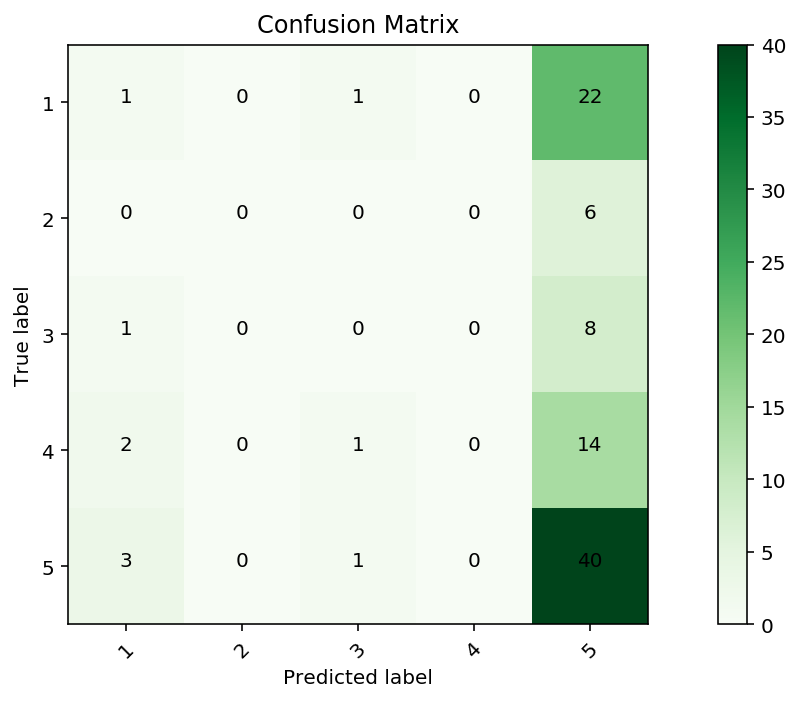

In [34]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['1', '2', '3', '4', '5'], 
              title='Confusion Matrix')
plt.show()

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();